In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticks
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs, nsdiffs
import missingno as miss
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import pmdarima as pm

pd.set_option('display.float_format',lambda x:f"{x:,.2f}")

In [2]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [3]:
def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [4]:
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [5]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)



    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()
    
    return fig

In [6]:
df = pd.read_csv('Data/City_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv')
df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,2000-01-31,2000-02-29,...,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,"253,690.00","255,517.00",...,"741,586.00","745,686.00","750,578.00","756,734.00","762,321.00","768,797.00","773,944.00","777,692.00","779,960.00","781,622.00"
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,"234,181.00","234,401.00",...,"924,019.00","928,991.00","937,936.00","953,874.00","973,168.00","990,391.00","992,337.00","992,630.00","978,196.00","966,595.00"
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,"109,068.00","109,079.00",...,"245,783.00","248,718.00","252,080.00","256,435.00","261,101.00","265,558.00","268,901.00","271,059.00","272,400.00","272,639.00"
3,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,"166,139.00","166,536.00",...,"302,821.00","305,104.00","306,404.00","308,303.00","309,649.00","312,487.00","314,663.00","315,910.00","315,587.00","315,429.00"
4,6915,4,San Antonio,city,TX,TX,"San Antonio-New Braunfels, TX",Bexar County,"114,794.00","114,975.00",...,"269,323.00","274,032.00","278,464.00","284,127.00","289,739.00","294,776.00","297,727.00","298,796.00","299,124.00","298,951.00"


In [7]:
filt_df = df.sort_values('SizeRank').head(4)
filt_df

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,2000-01-31,2000-02-29,...,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,"253,690.00","255,517.00",...,"741,586.00","745,686.00","750,578.00","756,734.00","762,321.00","768,797.00","773,944.00","777,692.00","779,960.00","781,622.00"
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,"234,181.00","234,401.00",...,"924,019.00","928,991.00","937,936.00","953,874.00","973,168.00","990,391.00","992,337.00","992,630.00","978,196.00","966,595.00"
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,"109,068.00","109,079.00",...,"245,783.00","248,718.00","252,080.00","256,435.00","261,101.00","265,558.00","268,901.00","271,059.00","272,400.00","272,639.00"
3,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,"166,139.00","166,536.00",...,"302,821.00","305,104.00","306,404.00","308,303.00","309,649.00","312,487.00","314,663.00","315,910.00","315,587.00","315,429.00"


In [8]:
id_vars = filt_df.columns[:8]
id_vars

Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'Metro', 'CountyName'],
      dtype='object')

In [42]:
long_df = pd.melt(filt_df, id_vars=id_vars, var_name='Date', value_name='Value')
long_df

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,Date,Value
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2000-01-31,"253,690.00"
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,2000-01-31,"234,181.00"
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,2000-01-31,"109,068.00"
3,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,2000-01-31,"166,139.00"
4,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2000-02-29,"255,517.00"
...,...,...,...,...,...,...,...,...,...,...
1087,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,2022-08-31,"315,587.00"
1088,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2022-09-30,"781,622.00"
1089,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,2022-09-30,"966,595.00"
1090,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,2022-09-30,"272,639.00"


In [43]:
fmt = "%Y-%m-%d"
long_df['Date'] = pd.to_datetime(long_df['Date'], format=fmt)
long_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1092 entries, 0 to 1091
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   RegionID    1092 non-null   int64         
 1   SizeRank    1092 non-null   int64         
 2   RegionName  1092 non-null   object        
 3   RegionType  1092 non-null   object        
 4   StateName   1092 non-null   object        
 5   State       1092 non-null   object        
 6   Metro       1092 non-null   object        
 7   CountyName  1092 non-null   object        
 8   Date        1092 non-null   datetime64[ns]
 9   Value       1087 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(6)
memory usage: 85.4+ KB


In [44]:
long_df = long_df.set_index('Date')
long_df.head(8)

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,Value
Date,,,,,,,,,
2000-01-31,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,"253,690.00"
2000-01-31,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,"234,181.00"
2000-01-31,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,"109,068.00"
2000-01-31,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,"166,139.00"
2000-02-29,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,"255,517.00"
2000-02-29,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,"234,401.00"
2000-02-29,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,"109,079.00"
2000-02-29,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,"166,536.00"


In [45]:
long_df.index

DatetimeIndex(['2000-01-31', '2000-01-31', '2000-01-31', '2000-01-31',
               '2000-02-29', '2000-02-29', '2000-02-29', '2000-02-29',
               '2000-03-31', '2000-03-31',
               ...
               '2022-07-31', '2022-07-31', '2022-08-31', '2022-08-31',
               '2022-08-31', '2022-08-31', '2022-09-30', '2022-09-30',
               '2022-09-30', '2022-09-30'],
              dtype='datetime64[ns]', name='Date', length=1092, freq=None)

In [46]:
long_df['RegionName'].unique()

array(['New York', 'Los Angeles', 'Houston', 'Chicago'], dtype=object)

In [51]:
ts = long_df.groupby('RegionName').resample('M').asfreq('M')
ts

RegionID  SizeRank RegionName RegionType StateName  \
RegionName Date                                                             
Chicago    2000-01-31     17426         3    Chicago       city        IL   
           2000-02-29     17426         3    Chicago       city        IL   
           2000-03-31     17426         3    Chicago       city        IL   
           2000-04-30     17426         3    Chicago       city        IL   
           2000-05-31     17426         3    Chicago       city        IL   
...                         ...       ...        ...        ...       ...   
New York   2022-05-31      6181         0   New York       city        NY   
           2022-06-30      6181         0   New York       city        NY   
           2022-07-31      6181         0   New York       city        NY   
           2022-08-31      6181         0   New York       city        NY   
           2022-09-30      6181         0   New York       city        NY   

                      State                                  Metro  \
RegionName Date                                                      
Chicago    2000-01-31    IL     Chicago-Naperville-Elgin, IL-IN-WI   
           2000-02-29    IL     Chicago-Naperville-Elgin, IL-IN-WI   
           2000-03-31    IL     Chicago-Naperville-Elgin, IL-IN-WI   
           2000-04-30    IL     Chicago-Naperville-Elgin, IL-IN-WI   
           2000-05-31    IL     Chicago-Naperville-Elgin, IL-IN-WI   
...                     ...                                    ...   
New York   2022-05-31    NY  New York-Newark-Jersey City, NY-NJ-PA   
           2022-06-30    NY  New York-Newark-Jersey City, NY-NJ-PA   
           2022-07-31    NY  New York-Newark-Jersey City, NY-NJ-PA   
           2022-08-31    NY  New York-Newark-Jersey City, NY-NJ-PA   
           2022-09-30    NY  New York-Newark-Jersey City, NY-NJ-PA   

                          CountyName      Value  
RegionName Date                                  
Chicago    2000-01-31    Cook County 166,139.00  
           2000-02-29    Cook County 166,536.00  
           2000-03-31    Cook County 167,368.00  
           2000-04-30    Cook County 168,826.00  
           2000-05-31    Cook County 170,499.00  
...                              ...        ...  
New York   2022-05-31  Queens County 768,797.00  
           2022-06-30  Queens County 773,944.00  
           2022-07-31  Queens County 777,692.00  
           2022-08-31  Queens County 779,960.00  
           2022-09-30  Queens County 781,622.00  

[1092 rows x 9 columns]

In [48]:
type(ts)

pandas.core.frame.DataFrame

In [49]:
ts.index

MultiIndex([( 'Chicago', '2000-01-31'),
            ( 'Chicago', '2000-02-29'),
            ( 'Chicago', '2000-03-31'),
            ( 'Chicago', '2000-04-30'),
            ( 'Chicago', '2000-05-31'),
            ( 'Chicago', '2000-06-30'),
            ( 'Chicago', '2000-07-31'),
            ( 'Chicago', '2000-08-31'),
            ( 'Chicago', '2000-09-30'),
            ( 'Chicago', '2000-10-31'),
            ...
            ('New York', '2021-12-31'),
            ('New York', '2022-01-31'),
            ('New York', '2022-02-28'),
            ('New York', '2022-03-31'),
            ('New York', '2022-04-30'),
            ('New York', '2022-05-31'),
            ('New York', '2022-06-30'),
            ('New York', '2022-07-31'),
            ('New York', '2022-08-31'),
            ('New York', '2022-09-30')],
           names=['RegionName', 'Date'], length=1092)

In [50]:
df_unstacked = ts.unstack(level=0)['Value']
df_unstacked.head()


RegionName,Chicago,Houston,Los Angeles,New York
Date,,,,
2000-01-31,"166,139.00","109,068.00","234,181.00","253,690.00"
2000-02-29,"166,536.00","109,079.00","234,401.00","255,517.00"
2000-03-31,"167,368.00","108,878.00","235,513.00","257,207.00"
2000-04-30,"168,826.00","108,881.00","237,589.00","260,310.00"
2000-05-31,"170,499.00","108,834.00","240,113.00","263,204.00"


In [18]:
def thousands(x,pos):
    """function for use wth matplotlib FuncFormatter -  formats money in millions"""
    new_x = x/1_000
    return f"{new_x:,.0f}K"

fmt_thous = mticks.FuncFormatter(thousands)


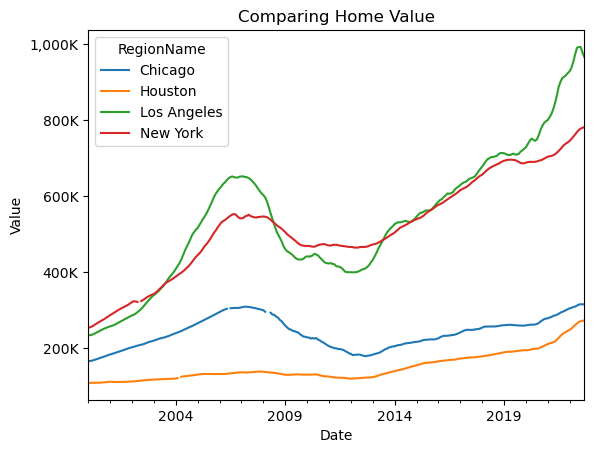

In [19]:
ax = df_unstacked.plot(ylabel='Value', title='Comparing Home Value')

ax.yaxis.set_major_formatter(fmt_thous)

1) Which City had the highest Typical Home Value at the end of 2008? Which had the least?

In [20]:
df_q1 = df_unstacked.loc['2008-12']
df_q1

RegionName,Chicago,Houston,Los Angeles,New York
Date,,,,
2008-12-31,"265,306.00","131,283.00","469,294.00","510,309.00"


- The city that has the highest typical home value at the end of 2008 is New York
- Houston has the lowest home value

2) How much did the home values change from November 2008 to December 2008 (in dollars)?

In [21]:
df_q2 = df_unstacked.loc['2008-11':'2008-12']
df_q2

RegionName,Chicago,Houston,Los Angeles,New York
Date,,,,
2008-11-30,"271,059.00","132,247.00","481,905.00","514,767.00"
2008-12-31,"265,306.00","131,283.00","469,294.00","510,309.00"


In [22]:
df_q2.diff()

RegionName,Chicago,Houston,Los Angeles,New York
Date,,,,
2008-11-30,NaN,NaN,NaN,NaN
2008-12-31,"-5,753.00",-964.00,"-12,611.00","-4,458.00"


- Chicago's home value went down 5,753 dollars
- Houston's home value went down 964 dollars
- Los Angeles's home value went down 12,611 dollars
- New Yorks's home value went down 4,458 dollars

In [73]:
NY = df_unstacked.loc['2018':,['New York']]
NY

RegionName,New York
Date,
2018-01-31,"656,700.00"
2018-02-28,"661,012.00"
2018-03-31,"665,672.00"
2018-04-30,"669,989.00"
2018-05-31,"673,514.00"
2018-06-30,"676,434.00"
2018-07-31,"678,984.00"
2018-08-31,"681,140.00"
2018-09-30,"683,546.00"


In [74]:
NY.isna().sum()

RegionName
New York    0
dtype: int64

In [75]:
NY = NY.interpolate()

In [76]:
NY.isnull().sum()

RegionName
New York    0
dtype: int64

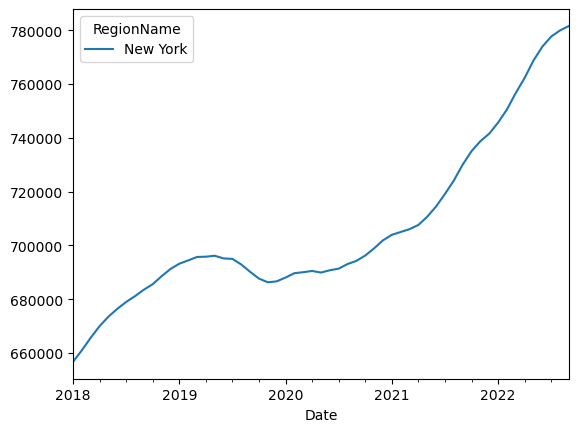

In [77]:
NY.plot();

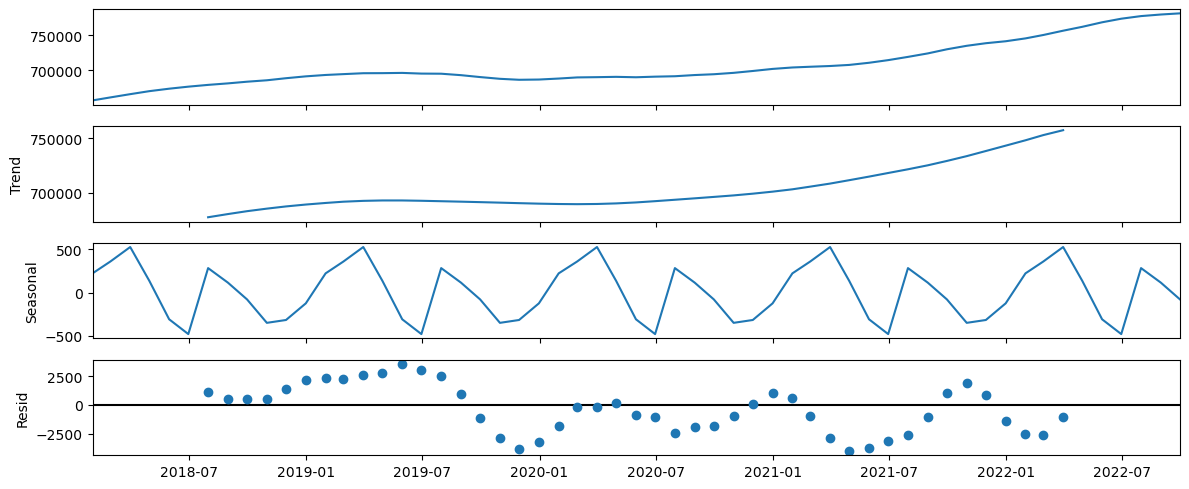

In [78]:
decomp = tsa.seasonal_decompose(NY)
fig = decomp.plot()
fig.set_size_inches(12,5)
fig.tight_layout()

In [79]:
seasonal_delta = decomp.seasonal.max() - decomp.seasonal.min()
print(f"The seasonal component is {seasonal_delta} which is ~{seasonal_delta/(NY.max()-NY.min())[0] * 100: .2f}% of the variation in time series.")

The seasonal component is 1006.1319444442925 which is ~ 0.81% of the variation in time series.


In [80]:
ndiffs(NY)

2

In [81]:
nsdiffs(NY, m = 12)

0

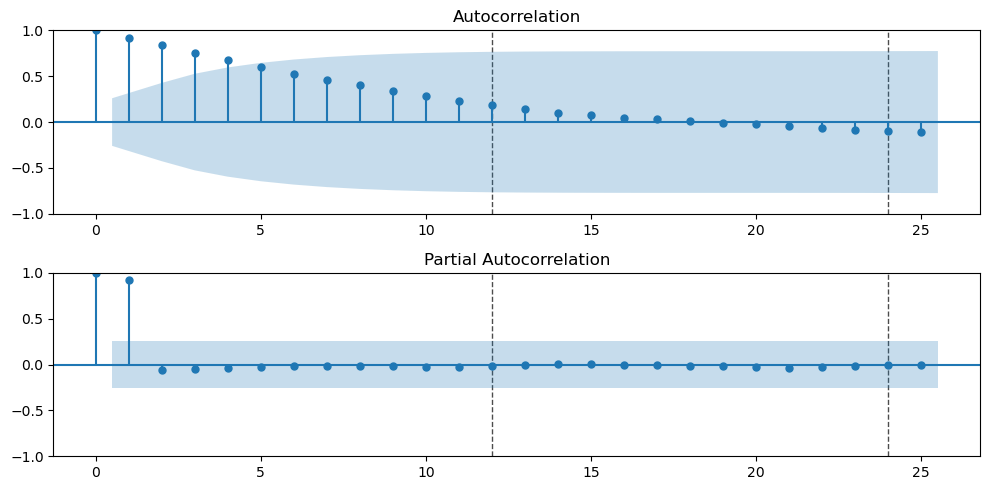

In [86]:
plot_acf_pacf(NY, annotate_seas=True, m = 12, nlags = 25);

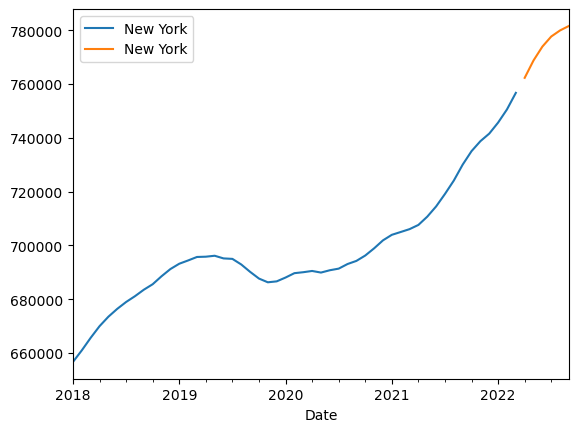

In [87]:
test_lags = 6
train, test = train_test_split(NY, test_size= test_lags)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

In [117]:
p = 1  # nonseasonal AR
d = 2  # nonseasonal differencing
q = 0  # nonseasonal MA

arima = tsa.ARIMA(train, order = (p,d,q)).fit()
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               New York   No. Observations:                   51
Model:                 ARIMA(1, 2, 0)   Log Likelihood                -402.198
Date:                Thu, 08 Feb 2024   AIC                            808.395
Time:                        21:59:25   BIC                            812.179
Sample:                    01-31-2018   HQIC                           809.831
                         - 03-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0014      0.097     -0.014      0.988      -0.191       0.188
sigma2      7.852e+05    2.2e+05      3.564      0.000    3.53e+05    1.22e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.30   Jarque-Bera (JB):                 1.89
Prob(Q):                              0.25   Prob(JB):                         0.39
Heteroskedasticity (H):               2.03   Skew:                            -0.02
Prob(H) (two-sided):                  0.17   Kurtosis:                         2.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

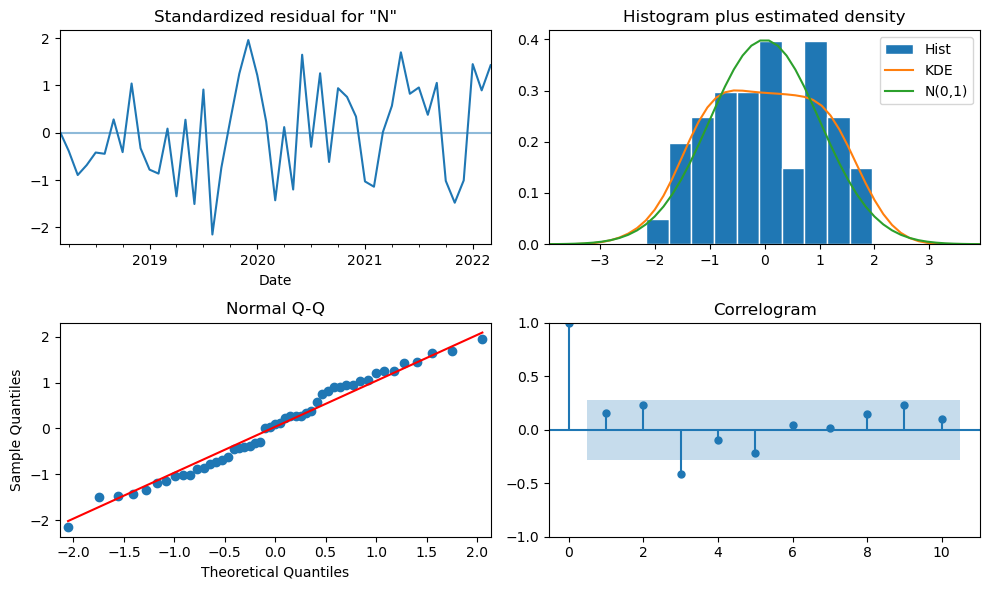

In [118]:
fig = arima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 4,217.822
- MSE = 36,194,677.245
- RMSE = 6,016.201
- R^2 = 0.198
- MAPE = 0.54%


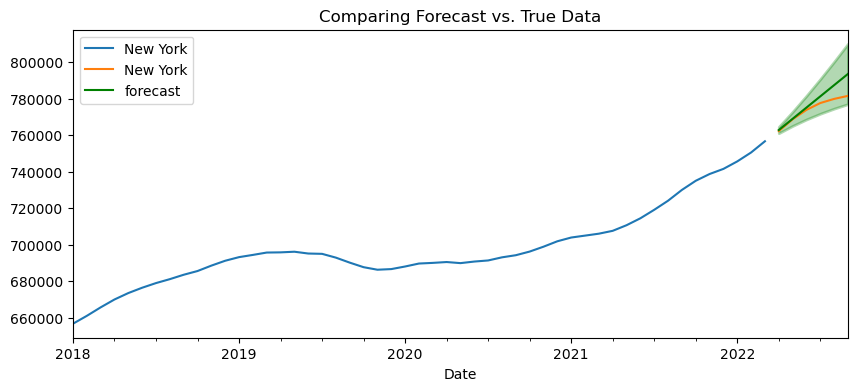

In [119]:
forecast_df = arima.get_forecast(steps=len(test)).summary_frame()
plot_forecast(train, test, forecast_df);
regression_metrics_ts(test, forecast_df['mean'])

In [123]:
P = 0  # Seasonal AR
D = 0  # Seasonal differencing
Q = 0  # Seasonal MA
m = 12 # Seasonal period

sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               New York   No. Observations:                   51
Model:                 ARIMA(1, 2, 0)   Log Likelihood                -402.198
Date:                Thu, 08 Feb 2024   AIC                            808.395
Time:                        22:00:43   BIC                            812.179
Sample:                    01-31-2018   HQIC                           809.831
                         - 03-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0014      0.097     -0.014      0.988      -0.191       0.188
sigma2      7.852e+05    2.2e+05      3.564      0.000    3.53e+05    1.22e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.30   Jarque-Bera (JB):                 1.89
Prob(Q):                              0.25   Prob(JB):                         0.39
Heteroskedasticity (H):               2.03   Skew:                            -0.02
Prob(H) (two-sided):                  0.17   Kurtosis:                         2.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

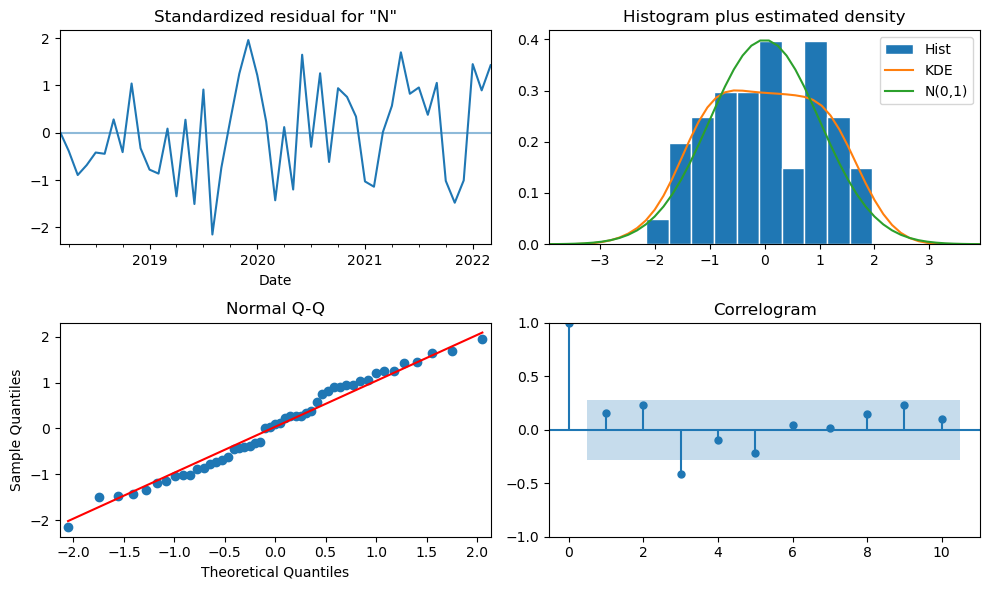

In [124]:
fig = sarima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 4,217.822
- MSE = 36,194,677.245
- RMSE = 6,016.201
- R^2 = 0.198
- MAPE = 0.54%


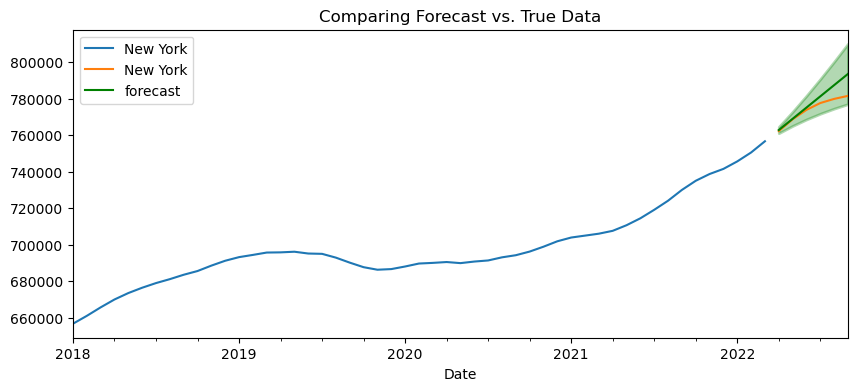

In [125]:
forecast_df = sarima.get_forecast(steps=len(test)).summary_frame()
plot_forecast(train, test, forecast_df);
regression_metrics_ts(test, forecast_df['mean'])

In [95]:
auto_model = pm.auto_arima(train, seasonal=True, m=12, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1040.347, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=909.717, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=930.102, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=912.587, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=940.569, Time=0.00 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=911.717, Time=0.02 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=911.717, Time=0.01 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=913.717, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=928.324, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=910.593, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=907.207, Time=0.05 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=909.209, Time=0.15 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=1024.876, Time=0.06 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=911.335, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[12] interc

In [96]:
print(auto_model.order)
print(auto_model.seasonal_order)

(1, 1, 1)
(0, 0, 0, 12)


In [114]:
p = 1 # nonseasonal AR
d = 1  # nonseasonal differencing
q = 1 # nonseasonal MA

# Orders for seasonal components
P = 0 # Seasonal AR
D = 0  # Seasonal differencing
Q = 0  # Seasonal MA
m = 12 # Seasonal period

auto_sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()
auto_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               New York   No. Observations:                   51
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -452.949
Date:                Thu, 08 Feb 2024   AIC                            911.898
Time:                        21:48:43   BIC                            917.634
Sample:                    01-31-2018   HQIC                           914.082
                         - 03-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.008    122.642      0.000       0.984       1.016
ma.L1         -0.9996      0.073    -13.656      0.000      -1.143      -0.856
sigma2      4.315e+06   4.01e-09   1.08e+15      0.000    4.32e+06    4.32e+06
===================================================================================
Ljung-Box (L1) (Q):                  39.10   Jarque-Bera (JB):                 0.53
Prob(Q):                              0.00   Prob(JB):                         0.77
Heteroskedasticity (H):               2.15   Skew:                            -0.20
Prob(H) (two-sided):                  0.12   Kurtosis:                         2.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.76e+29. Standard errors may be unstable.
"""

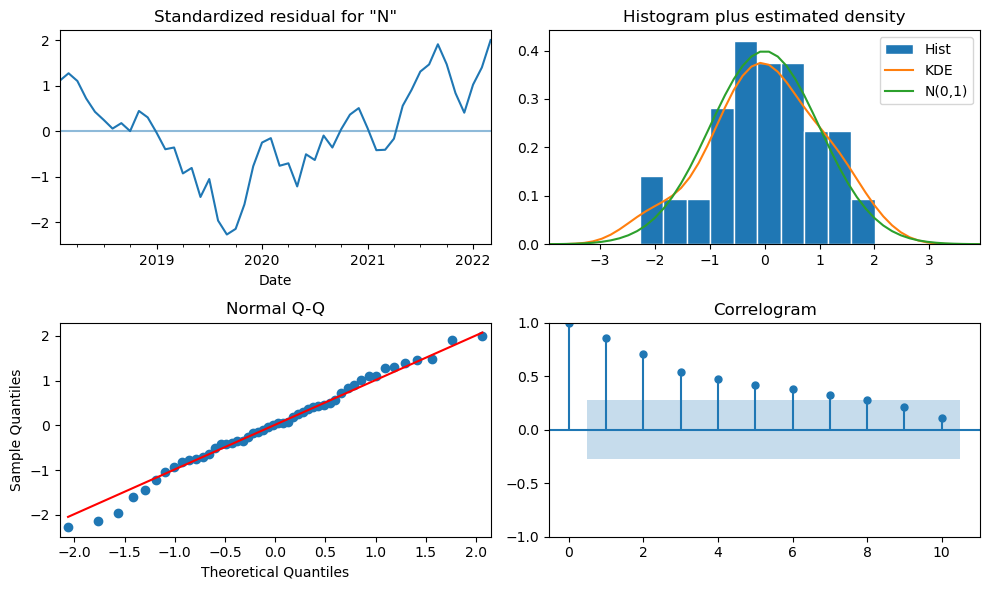

In [115]:
fig = auto_sarima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 10,336.391
- MSE = 119,088,166.132
- RMSE = 10,912.752
- R^2 = -1.640
- MAPE = 1.33%


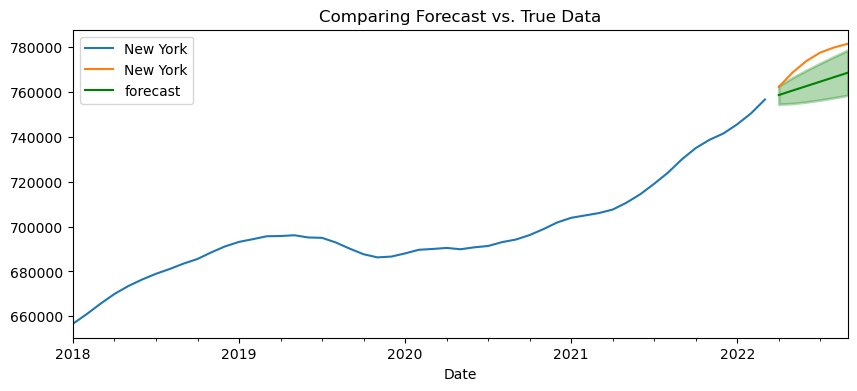

In [116]:
forecast_df = auto_sarima.get_forecast(len(test)).summary_frame()
plot_forecast(train, test, forecast_df)
regression_metrics_ts(test, forecast_df["mean"])

- The model that was recommended by the auto arima performed worse than the initial model I made before. I am going to continue with the components as (1,2,0)(0,0,0)[12].

In [126]:
forecast_df.index[0],forecast_df.index[-1]

(Timestamp('2022-04-30 00:00:00', freq='M'),
 Timestamp('2022-09-30 00:00:00', freq='M'))

In [127]:
starting_value = forecast_df['mean'].iloc[0]
starting_value

762888.2331520646

In [128]:
final_value = forecast_df['mean'].iloc[-1]
final_value

793659.4112472942

In [129]:
change = final_value - starting_value
change

30771.178095229552

In [130]:
perc_change = (change / starting_value) * 100
perc_change

4.033510645208236

- The predicted home value in New York City in 6 months is $793,659.
- That is a 4% increase in the home values.